In [1]:
#!pip install -U transformers
#!pip install -U datasets
#!pip install optuna
import os
import sys
HOME = os.path.abspath('..')
sys.path.append(HOME)
os.chdir(HOME)
import pandas as pd
#!pip install transformers
from transformers import RobertaConfig, RobertaModel,RobertaForSequenceClassification, Trainer,AutoModelForSequenceClassification, EarlyStoppingCallback 
from transformers import AutoTokenizer
from transformers.models.roberta import RobertaPreTrainedModel
import torch
from torch import nn
from transformers import TrainingArguments
import glob
import optuna
from itertools import product
import numpy as np
from pprint import pprint

In [126]:
MODEL_NAME =  "distilbert-base-uncased" #"roberta-base" 
TARGET_COL = 'revenue_worldwide_BOM'#'averageRating'
MODEL_FOLDER = 'only_text_features'#'everything_as_text'
text_input_col = 'text_input'
CATEGORIES_AS_TEXT = False
NUMERIC_AS_TEXT = False
DATE_AS_TEXT = False
ADJUST_INFLATION = False
USE_COLUMN_NAMES = False
COLAB = False
DEBUG = False

FINAL_MODEL_NAME = f"{MODEL_NAME}-{TARGET_COL}"

if ADJUST_INFLATION:
    FINAL_MODEL_NAME+='-inflation_adjusted'
    
if USE_COLUMN_NAMES:
    FINAL_MODEL_NAME+='-with_column_names'
    

FINAL_MODEL_PATH = f'models/{MODEL_FOLDER}/{FINAL_MODEL_NAME}'
TRIALS_DF_PATH = f'models/{MODEL_FOLDER}/{FINAL_MODEL_NAME}_hparams_trials.csv'
TEST_PERFORMANCE_PATH = f'models/{MODEL_FOLDER}/{FINAL_MODEL_NAME}_test_stats_best_model.csv'
    
if USE_COLUMN_NAMES:
    assert CATEGORIES_AS_TEXT|NUMERIC_AS_TEXT|DATE_AS_TEXT, "can't use column names as text if there are no columns to treat as text!"
    
print('Final model name: ',FINAL_MODEL_NAME)
print('Saving at: ',MODEL_FOLDER)


if COLAB == True:
  if not os.path.exists('data'):
    os.mkdir('data')
  if not os.path.exists('data/processed'):
    os.mkdir('data/processed')

  drive.mount('/content/gdrive/')
  for filename in glob.glob(os.path.join('gdrive/MyDrive/atdl', '*.*')):
      shutil.copy(filename, 'data/processed')
    


Final model name:  distilbert-base-uncased-revenue_worldwide_BOM
Saving at:  only_text_features


In [127]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def process_text_data(data_:pd.DataFrame,text_col,padding ="max_length", truncation = True, na_filler = ""):

    '''
    
    '''
    data = data_.copy()
    data[text_col] = data[text_col].fillna(na_filler)
    encodings = tokenizer(data[text_col].tolist(), padding=padding, truncation=truncation)
    return encodings
    

def columns_to_single_text(df,cols_to_transform,new_col_name = 'text_input',sep = tokenizer.sep_token,nan_replacement = tokenizer.unk_token ):

  '''
  
  Creates a new column called new_col_name with with all columns in cols_to_transform concatenated into a single text
  '''
  df[new_col_name] = df[cols_to_transform].astype(str).replace('nan',nan_replacement).agg(f' {sep} '.join, axis=1)


class NAFiller:

  def __init__(self,train):
    self.train = train

  def fit(self,column = 'Budget',groupby=['top_genre','top_country']):
    self.mapping = self.train.groupby(groupby)[column].median().reset_index()
    self.mapping = self.mapping.rename(columns={column:'na_filler'})
    self.median = self.train[column].median()
    self.column=column


  def transform(self,test,round = False):
    self.na_filler = test.merge(self.mapping,how='left')['na_filler']
    self.na_filler = self.na_filler.fillna(self.median)

    test[self.column] = test[self.column].reset_index(drop=True).fillna(self.na_filler).values

    if round:
      test[self.column] = test[self.column].round().astype(int)
      


  def fit_transform(self,test,column = 'Budget',groupby=['top_genre','top_country']):
    self.fit(column,groupby)
    self.transform()
    self.column=column
        

def create_dataset_split(split,text_cols,text_input_col,TARGET_COL):
    
  if TARGET_COL == 'revenue_worldwide_BOM':
    split[TARGET_COL] = np.log1p(split[TARGET_COL])
    print('log transforming target')
    

  #If all columns in text_cols are combined into a single text. A n
  columns_to_single_text(split,text_cols)

  #Get split encodings
  split_encodings = process_text_data(split,text_input_col)

  #get labels
  split_labels = split[TARGET_COL].tolist()

  #Create dataset objects
  split_dataset = IMDbDataset(split_encodings, split_labels)

  return split_dataset


def get_model():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                         problem_type='regression',
                                                         num_labels=1)
def get_model_by_name(model_name):
    return AutoModelForSequenceClassification.from_pretrained(model_name,
                                                         problem_type='regression',
                                                         num_labels=1
                                                        )                                              


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/jupyter/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /home/jupyter/.cache/huggingface/transformers/0e1bbfda7f63a

In [128]:
all_cols =  ['Budget',
             'averageRating',
             'cast',
             'countries',
             'director',
             'genres',
             'imdb_id',
             'languages',
             'overview',
             'production companies',
             'release_date',
             'revenue_worldwide_BOM',
             'runtimeMinutes',
             'title']

categoric_cols = ['cast',
                  'countries',
                  'director',
                  'genres',
                  'languages',
                  'production companies']

text_cols = ['title','overview']                  
date_cols = ['release_date']
numeric_cols = ['Budget','runtimeMinutes']

if CATEGORIES_AS_TEXT:
  text_cols+=categoric_cols

if NUMERIC_AS_TEXT:
  text_cols+=numeric_cols

if DATE_AS_TEXT:
  text_cols+=date_cols

train_ids = pd.read_csv('data/processed/train.csv',usecols=['imdb_id'])['imdb_id'].tolist()
val_ids = pd.read_csv('data/processed/val.csv',usecols=['imdb_id'])['imdb_id'].tolist()
test_ids = pd.read_csv('data/processed/test.csv',usecols=['imdb_id'])['imdb_id'].tolist()
df = pd.read_csv('data/processed/df.csv',usecols = all_cols,parse_dates=['release_date']).sample(frac=1,random_state=42) #shuffle


df[categoric_cols] = df[categoric_cols].apply(lambda x: x.str.replace('|',', '),axis=0) #Change pipe to comma, its more meaningful

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [129]:
#Additional auxilary columns
df['top_genre'] = df['genres'].apply(lambda x: x.split(', ')[0])
df['top_country'] = df['countries'].apply(lambda x: x.split(', ')[0] if isinstance(x,str) else x)
df['year'] = df['release_date'].dt.year

In [130]:
#Create splits
if DEBUG:
    train = df[df['imdb_id'].isin(train_ids)].sample(frac=0.2)
    val = df[df['imdb_id'].isin(val_ids)].sample(frac=0.2)
    test = df[df['imdb_id'].isin(test_ids)]
else:
    train = df[df['imdb_id'].isin(train_ids)]
    val = df[df['imdb_id'].isin(val_ids)]
    test = df[df['imdb_id'].isin(test_ids)]


#Fill na in some columns with statistics
naf = NAFiller(train)
naf.fit(column = 'Budget',groupby=['top_genre','top_country'])
naf.transform(train,round=True)
naf.transform(val,round=True)
naf.transform(test,round=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [131]:
train_dataset=create_dataset_split(train,text_cols,text_input_col,TARGET_COL)
val_dataset=create_dataset_split(val,text_cols,text_input_col,TARGET_COL)
test_dataset=create_dataset_split(test,text_cols,text_input_col,TARGET_COL)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


log transforming target
log transforming target
log transforming target


In [132]:
#Example of input to language model
train['text_input'].iloc[15]

"Dedication [SEP] A modern love story in which a misanthropic, emotionally complex author of a hit children's book is forced to team with a beautiful illustrator after his best friend and collaborator passes away. As Henry struggles with letting go of the ghosts of love and life, he discovers that sometimes you have to take a gamble at life to find love."

In [133]:
import csv
class DictWriter:
    
    def __init__(self,file_path,field_names):
        self.field_names = field_names
        self.file_path = file_path
        self.create_file() #Crerate file if it doesnt exist.
        
    def create_file(self):
        if not os.path.exists(self.file_path):
            print('creating file')
            f = open(self.file_path, 'w')
            w = csv.DictWriter(f, field_names)
            w.writeheader()
            f.close()
        else:
            print('file already exist. Will append rows to it.')
            
    def add_rows(self,rows):  
        with open(self.file_path, 'a') as f:
            w = csv.DictWriter(f,self.field_names)
            for r in rows:    
                w.writerow(r)        

In [ ]:
epochs = 15
num_evals = 20
patience = 2 if DEBUG else 30
callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
eval_steps = 50 if DEBUG else 100


hparams = {'batch_size' : [8,16,32],
           'learning_rate' : [1e-5, 2e-5, 3e-5,5e-5],
           'weight_decay' : [0.1,0.01],
           'repeats': range(1)}

combs = list(product(*[range(len(i)) for i in list(hparams.values())]))
scores = np.zeros([len(i) for i in list(hparams.values())])

#trials_df_rows = []

field_names = list(hparams.keys()) + ['score']
dw = DictWriter(TRIALS_DF_PATH,field_names)

currernt_trials_df = pd.read_csv(TRIALS_DF_PATH) #This can be empty or not.
done_trials = currernt_trials_df.drop('score',axis=1).to_dict(orient='records') #empty list or not
best_score = min(float('inf'),currernt_trials_df['score'].min())

print(f'current best val score = {best_score}')

for idx,comb_indexes in enumerate(combs):
    comb_values = {name:val[idx] for name,val,idx in zip(hparams.keys(),hparams.values(),comb_indexes)}
    
    if comb_values not in done_trials: #Check if trial alrready exists. If it does, skip.
        print('training with following hparams:')
        pprint(comb_values)

        training_args = TrainingArguments(output_dir=f"{MODEL_NAME}-{TARGET_COL}",
                                          per_device_train_batch_size = comb_values['batch_size'],
                                          learning_rate=comb_values['learning_rate'],
                                          weight_decay=comb_values['weight_decay'],
                                          seed = 42,
                                          fp16=True,
                                          per_device_eval_batch_size = 16,
                                          warmup_ratio=0.06,
                                          num_train_epochs = epochs,
                                          evaluation_strategy = "steps",
                                          save_strategy = "steps",
                                          load_best_model_at_end=True,
                                          eval_steps = eval_steps,
                                          save_steps = eval_steps,
                                          save_total_limit = 1,
                                          log_level = 'error',
                                          disable_tqdm = True

                                        )

        trainer = Trainer(
            model_init=get_model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            callbacks = callbacks
        )
        


        trainer.train()

        score = trainer.evaluate()['eval_loss']

        scores[tuple(comb_indexes)] = score #outdated

        comb_values['score'] = score

        dw.add_rows([comb_values]) #Append to dataframe

        #trials_df_rows.append(comb_values)

        if score<best_score:
            print(f'got a better model, with score {np.round(score,4)} saving...')
            best_score = score
            trainer.save_model(FINAL_MODEL_PATH)
            
            print('saved')
    else:
        print('skipping trial because already exists')


#trials_df = pd.DataFrame(trials_df_rows)
#trials_df.to_csv(f'models/{MODEL_FOLDER}/hparams_trials.csv',index=False)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


creating file
current best val score = inf
training with following hparams:
{'batch_size': 8, 'learning_rate': 1e-05, 'repeats': 0, 'weight_decay': 0.1}


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 187.10223388671875, 'eval_runtime': 11.8838, 'eval_samples_per_second': 147.596, 'eval_steps_per_second': 9.256, 'epoch': 0.1}
{'eval_loss': 151.21286010742188, 'eval_runtime': 10.8619, 'eval_samples_per_second': 161.482, 'eval_steps_per_second': 10.127, 'epoch': 0.2}
{'eval_loss': 106.61065673828125, 'eval_runtime': 10.8422, 'eval_samples_per_second': 161.776, 'eval_steps_per_second': 10.146, 'epoch': 0.29}
{'eval_loss': 75.53141021728516, 'eval_runtime': 11.1126, 'eval_samples_per_second': 157.839, 'eval_steps_per_second': 9.899, 'epoch': 0.39}
{'loss': 158.9443, 'learning_rate': 5.347071583514101e-06, 'epoch': 0.49}
{'eval_loss': 52.29413986206055, 'eval_runtime': 10.9065, 'eval_samples_per_second': 160.821, 'eval_steps_per_second': 10.086, 'epoch': 0.49}
{'eval_loss': 32.83210372924805, 'eval_runtime': 10.8145, 'eval_samples_per_second': 162.19, 'eval_steps_per_second': 10.172, 'epoch': 0.59}
{'eval_loss': 18.418102264404297, 'eval_runtime': 10.9246, 'eval_samples_per

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 187.10226440429688, 'eval_runtime': 11.026, 'eval_samples_per_second': 159.078, 'eval_steps_per_second': 9.976, 'epoch': 0.1}
{'eval_loss': 151.20664978027344, 'eval_runtime': 11.0179, 'eval_samples_per_second': 159.195, 'eval_steps_per_second': 9.984, 'epoch': 0.2}
{'eval_loss': 106.6106948852539, 'eval_runtime': 10.9522, 'eval_samples_per_second': 160.15, 'eval_steps_per_second': 10.044, 'epoch': 0.29}
{'eval_loss': 75.5217056274414, 'eval_runtime': 10.9155, 'eval_samples_per_second': 160.688, 'eval_steps_per_second': 10.077, 'epoch': 0.39}
{'loss': 158.9369, 'learning_rate': 5.347071583514101e-06, 'epoch': 0.49}
{'eval_loss': 52.27341842651367, 'eval_runtime': 10.9398, 'eval_samples_per_second': 160.332, 'eval_steps_per_second': 10.055, 'epoch': 0.49}
{'eval_loss': 32.81000900268555, 'eval_runtime': 10.9106, 'eval_samples_per_second': 160.761, 'eval_steps_per_second': 10.082, 'epoch': 0.59}
{'eval_loss': 18.398937225341797, 'eval_runtime': 10.8403, 'eval_samples_per_se

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 178.47328186035156, 'eval_runtime': 11.0219, 'eval_samples_per_second': 159.138, 'eval_steps_per_second': 9.98, 'epoch': 0.1}
{'eval_loss': 116.63774108886719, 'eval_runtime': 10.9747, 'eval_samples_per_second': 159.823, 'eval_steps_per_second': 10.023, 'epoch': 0.2}
{'eval_loss': 71.23792266845703, 'eval_runtime': 10.9172, 'eval_samples_per_second': 160.664, 'eval_steps_per_second': 10.076, 'epoch': 0.29}
{'eval_loss': 39.815982818603516, 'eval_runtime': 10.8887, 'eval_samples_per_second': 161.084, 'eval_steps_per_second': 10.102, 'epoch': 0.39}
{'loss': 127.8807, 'learning_rate': 1.0715835140997832e-05, 'epoch': 0.49}
{'eval_loss': 17.847169876098633, 'eval_runtime': 10.9036, 'eval_samples_per_second': 160.864, 'eval_steps_per_second': 10.088, 'epoch': 0.49}
{'eval_loss': 13.283844947814941, 'eval_runtime': 10.8827, 'eval_samples_per_second': 161.174, 'eval_steps_per_second': 10.108, 'epoch': 0.59}
{'eval_loss': 14.884015083312988, 'eval_runtime': 10.9104, 'eval_samples

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 178.47145080566406, 'eval_runtime': 11.0426, 'eval_samples_per_second': 158.839, 'eval_steps_per_second': 9.961, 'epoch': 0.1}
{'eval_loss': 116.63801574707031, 'eval_runtime': 10.9698, 'eval_samples_per_second': 159.894, 'eval_steps_per_second': 10.028, 'epoch': 0.2}
{'eval_loss': 71.22618865966797, 'eval_runtime': 10.8927, 'eval_samples_per_second': 161.025, 'eval_steps_per_second': 10.098, 'epoch': 0.29}
{'eval_loss': 39.79200744628906, 'eval_runtime': 10.8843, 'eval_samples_per_second': 161.15, 'eval_steps_per_second': 10.106, 'epoch': 0.39}
{'loss': 127.871, 'learning_rate': 1.0715835140997832e-05, 'epoch': 0.49}
{'eval_loss': 17.83082389831543, 'eval_runtime': 10.8804, 'eval_samples_per_second': 161.208, 'eval_steps_per_second': 10.11, 'epoch': 0.49}
{'eval_loss': 13.28560733795166, 'eval_runtime': 10.918, 'eval_samples_per_second': 160.652, 'eval_steps_per_second': 10.075, 'epoch': 0.59}
{'eval_loss': 15.070405960083008, 'eval_runtime': 10.8736, 'eval_samples_per_s

In [10]:
#Test set performance
best_model = get_model_by_name(FINAL_MODEL_PATH)
trainer_best_model = Trainer(model=best_model)

predictions = trainer_best_model.predict(test_dataset)
preds = predictions.predictions.flatten() 
labels = predictions.label_ids

if TARGET_COL == 'revenue_worldwide_BOM':
    preds = np.expm1(preds)
    labels = np.expm1(labels)


mse = ((preds-labels)**2).mean()
mae = (np.abs(preds-labels)).mean()
errors = {'MAE':mae,'MSE':mse,'RMSE':np.sqrt(mse)}
pd.DataFrame([errors]).to_csv(TEST_PERFORMANCE_PATH,
                              index=False)


***** Running Prediction *****
  Num examples = 1754
  Batch size = 8


(array([  2.,   4.,  17.,  34.,  53.,  64.,  70., 102.,  81.,  89.,  91.,
         84.,  74.,  73.,  76.,  55.,  56.,  51.,  48.,  41.,  26.,  30.,
         31.,  20.,  27.,  29.,  21.,  24.,  20.,  14.,  30.,  20.,  27.,
         24.,  31.,  22.,  27.,  52.,  45.,  69.]),
 array([ 8.904737 ,  9.151753 ,  9.398769 ,  9.645784 ,  9.8928   ,
        10.139816 , 10.386832 , 10.633848 , 10.880863 , 11.127879 ,
        11.374895 , 11.621911 , 11.868927 , 12.115942 , 12.362958 ,
        12.609974 , 12.85699  , 13.104006 , 13.351021 , 13.598037 ,
        13.845053 , 14.092069 , 14.339085 , 14.5861   , 14.833116 ,
        15.080132 , 15.3271475, 15.574163 , 15.821178 , 16.068195 ,
        16.31521  , 16.562225 , 16.809242 , 17.056257 , 17.303274 ,
        17.55029  , 17.797304 , 18.044321 , 18.291336 , 18.538353 ,
        18.785368 ], dtype=float32),
 <BarContainer object of 40 artists>)

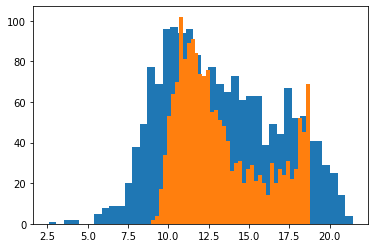

In [110]:
import matplotlib.pyplot as plt
from scipy.stats import boxcox
plt.hist(np.log1p(labels),bins=40)
plt.hist(np.log1p(preds),bins=40)

#plt.xscale('log')